# Trigrams - MakeMore2 (19/04/2023)

In [119]:
# https://youtu.be/TCH_1BHY58I
# https://github.com/karpathy/makemore 

Now we'll try to build a multilayer perceptron (MLP).
Each character is going to be embedded in a 2D space.
We've three vectors 30D, so 90D as total dimension. (28 chars + 2)
Training the network the embedding will change.
We'll have a linear transformation which transpose in an intermediate layer we can see as 100D vector.
Transforming this non-linearly (with a hyperbolic tangent) it will construct the derivatives (back propagation).
With another linear transform we'll connect all.
Exponentiating and normalizing we'll get the desired probability distribution.
Hyperparameters are the a priori defined parameters.
To do things in a good way one needs to know how to tune the hyperparameters.

In [120]:
# we now go to MLP (multilayer perceptron)....(using NLP (natural language processing))
# 'a neural probabilistic language model' (2003) chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/
# https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf
# fig 1: 4th word predicted after the three....
import random
import torch
import torch.nn.functional as  F
import matplotlib.pyplot as plt
%matplotlib inline

In [121]:
# read in all the words
random.seed(158)
words=open('data/nomi_italiani.txt','r').read().splitlines()
random.shuffle(words)
print(words[0:10])
print(len(words))

['argento', 'giovannino', 'licurga', 'elvira', 'marena', 'sirio', 'emilia', 'bisio', 'preziosa', 'perpetua']
9105


In [122]:
# build the vocabulary of characters and mapping to/from integers
chars=sorted(list(set(''.join(words))))

stoi={s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos ={i:s for s,i in stoi.items()}
print(itos)
print(stoi)

{1: '-', 2: 'a', 3: 'b', 4: 'c', 5: 'd', 6: 'e', 7: 'f', 8: 'g', 9: 'h', 10: 'i', 11: 'j', 12: 'k', 13: 'l', 14: 'm', 15: 'n', 16: 'o', 17: 'p', 18: 'q', 19: 'r', 20: 's', 21: 't', 22: 'u', 23: 'v', 24: 'w', 25: 'x', 26: 'y', 27: 'z', 0: '.'}
{'-': 1, 'a': 2, 'b': 3, 'c': 4, 'd': 5, 'e': 6, 'f': 7, 'g': 8, 'h': 9, 'i': 10, 'j': 11, 'k': 12, 'l': 13, 'm': 14, 'n': 15, 'o': 16, 'p': 17, 'q': 18, 'r': 19, 's': 20, 't': 21, 'u': 22, 'v': 23, 'w': 24, 'x': 25, 'y': 26, 'z': 27, '.': 0}


Previous example - Markov chain, so the block size was 1.
Updating the contest means shift over the string and add the last character.
X contains the samples (what I'm looking at).
Each row of X is a trigram.
Y contains the correct answers.

In [123]:
# build the dataset

block_size = 3 #context length: how many characters do we take to predict the next one ... change it !!
# try: block_size=1 ...Markov Chain, then try = 2 and =10
X,Y = [],[]  # input & label

for w in words[0:5]:
    print(w)
    context=[0]*block_size # 000 corresponds to the character '...'
    for ch in w +'.':
        ix=stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '--->', itos[ix])
        context=context[1:]+[ix]  # shift: crop and append
X=torch.tensor(X)
Y=torch.tensor(Y)

argento
... ---> a
..a ---> r
.ar ---> g
arg ---> e
rge ---> n
gen ---> t
ent ---> o
nto ---> .
giovannino
... ---> g
..g ---> i
.gi ---> o
gio ---> v
iov ---> a
ova ---> n
van ---> n
ann ---> i
nni ---> n
nin ---> o
ino ---> .
licurga
... ---> l
..l ---> i
.li ---> c
lic ---> u
icu ---> r
cur ---> g
urg ---> a
rga ---> .
elvira
... ---> e
..e ---> l
.el ---> v
elv ---> i
lvi ---> r
vir ---> a
ira ---> .
marena
... ---> m
..m ---> a
.ma ---> r
mar ---> e
are ---> n
ren ---> a
ena ---> .


In [124]:
print(X)
print(Y)

tensor([[ 0,  0,  0],
        [ 0,  0,  2],
        [ 0,  2, 19],
        [ 2, 19,  8],
        [19,  8,  6],
        [ 8,  6, 15],
        [ 6, 15, 21],
        [15, 21, 16],
        [ 0,  0,  0],
        [ 0,  0,  8],
        [ 0,  8, 10],
        [ 8, 10, 16],
        [10, 16, 23],
        [16, 23,  2],
        [23,  2, 15],
        [ 2, 15, 15],
        [15, 15, 10],
        [15, 10, 15],
        [10, 15, 16],
        [ 0,  0,  0],
        [ 0,  0, 13],
        [ 0, 13, 10],
        [13, 10,  4],
        [10,  4, 22],
        [ 4, 22, 19],
        [22, 19,  8],
        [19,  8,  2],
        [ 0,  0,  0],
        [ 0,  0,  6],
        [ 0,  6, 13],
        [ 6, 13, 23],
        [13, 23, 10],
        [23, 10, 19],
        [10, 19,  2],
        [ 0,  0,  0],
        [ 0,  0, 14],
        [ 0, 14,  2],
        [14,  2, 19],
        [ 2, 19,  6],
        [19,  6, 15],
        [ 6, 15,  2]])
tensor([ 2, 19,  8,  6, 15, 21, 16,  0,  8, 10, 16, 23,  2, 15, 15, 10, 15, 16,
         0, 13, 1

In [125]:
print(X.shape, X.dtype, Y.shape, Y.dtype)

torch.Size([41, 3]) torch.int64 torch.Size([41]) torch.int64


Now we want to predict the next character starting from trigrams.
We're going to take a 2D embedding of the 28 characters.
There are many pre-calculated embeddings in the world.

We can generate a random (normal) matrix 28x2.
In deep data analysis (what we're doing) the world is going really fast.
There is a lot of material, 99% of which are bullshits.

In [126]:
C = torch.randn((28,2))  #https://pytorch.org/docs/stable/generated/torch.randn.html

In [127]:
print(C[5])
print(C.shape)

tensor([0.1602, 1.6865])
torch.Size([28, 2])


Here is a plot of the embedding.
Letters are random, after the training this picture is going to change.
From this plot we can learn how characters are related each other.

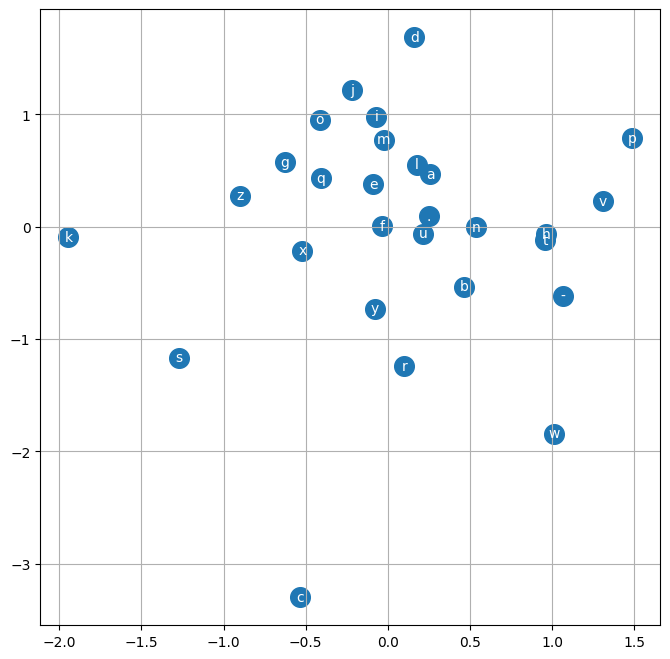

In [128]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data,s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(),itos[i], ha="center",va="center", color="white")
    plt.grid('minor')


Another way to embed characters is the one-hot embedding discussed last lecture.
We can see this embedding as the first layer of our network, even if there's no linearity in it.
In fact, they're completely equivalent.
One can also see all the embeddings.

In [129]:
print(F.one_hot(torch.tensor(5),num_classes=28))
print(F.one_hot(torch.tensor(5),num_classes=28).float()@C)
print(C[5])
print(C[Y])

tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])
tensor([0.1602, 1.6865])
tensor([0.1602, 1.6865])
tensor([[ 0.2558,  0.4712],
        [ 0.1004, -1.2394],
        [-0.6255,  0.5749],
        [-0.0888,  0.3804],
        [ 0.5361, -0.0062],
        [ 0.9571, -0.1212],
        [-0.4138,  0.9524],
        [ 0.2496,  0.0927],
        [-0.6255,  0.5749],
        [-0.0697,  0.9788],
        [-0.4138,  0.9524],
        [ 1.3095,  0.2283],
        [ 0.2558,  0.4712],
        [ 0.5361, -0.0062],
        [ 0.5361, -0.0062],
        [-0.0697,  0.9788],
        [ 0.5361, -0.0062],
        [-0.4138,  0.9524],
        [ 0.2496,  0.0927],
        [ 0.1741,  0.5519],
        [-0.0697,  0.9788],
        [-0.5335, -3.2989],
        [ 0.2131, -0.0609],
        [ 0.1004, -1.2394],
        [-0.6255,  0.5749],
        [ 0.2558,  0.4712],
        [ 0.2496,  0.0927],
        [-0.0888,  0.3804],
        [ 0.1741,  0.5519],
        [ 1.3095,  0.2283],
        [

How to embed the 41 trigrams we have?

In [130]:
emb = C[X]
print(emb.shape)

torch.Size([41, 3, 2])


Moreover, we can *differentiate* C!
Input has dimension 6 = 3 * 2

In [140]:
# construct the Layer.... x.W+ b ... so the input has dimension 6=3*2 for (say) 100 neurons...
W1 = torch.randn(6,100)
b1 = torch.randn(100)


We want to concatenate tensors.
And maybe unbind them.

In [141]:
# https://pytorch.org/docs/stable/torch.html search for concatenate...

print(torch.cat([emb[:,0,:],emb[:,1,:],emb[:,2,:]],1)[1])
print(emb[1])
#torch.cat([emb[:,0,:],emb[:,1,:],emb[:,2,:]],1).shape


tensor([0.2496, 0.0927, 0.2496, 0.0927, 0.2558, 0.4712])
tensor([[0.2496, 0.0927],
        [0.2496, 0.0927],
        [0.2558, 0.4712]])


In [142]:
# we want a code for general n-grams..... 
# use 'unbind' https://pytorch.org/docs/stable/generated/torch.unbind.html#torch.unbind
len(torch.unbind(emb,1))


3

In [143]:
# and this work fore any context length.......

torch.cat(torch.unbind(emb,1),1)

tensor([[ 0.2496,  0.0927,  0.2496,  0.0927,  0.2496,  0.0927],
        [ 0.2496,  0.0927,  0.2496,  0.0927,  0.2558,  0.4712],
        [ 0.2496,  0.0927,  0.2558,  0.4712,  0.1004, -1.2394],
        [ 0.2558,  0.4712,  0.1004, -1.2394, -0.6255,  0.5749],
        [ 0.1004, -1.2394, -0.6255,  0.5749, -0.0888,  0.3804],
        [-0.6255,  0.5749, -0.0888,  0.3804,  0.5361, -0.0062],
        [-0.0888,  0.3804,  0.5361, -0.0062,  0.9571, -0.1212],
        [ 0.5361, -0.0062,  0.9571, -0.1212, -0.4138,  0.9524],
        [ 0.2496,  0.0927,  0.2496,  0.0927,  0.2496,  0.0927],
        [ 0.2496,  0.0927,  0.2496,  0.0927, -0.6255,  0.5749],
        [ 0.2496,  0.0927, -0.6255,  0.5749, -0.0697,  0.9788],
        [-0.6255,  0.5749, -0.0697,  0.9788, -0.4138,  0.9524],
        [-0.0697,  0.9788, -0.4138,  0.9524,  1.3095,  0.2283],
        [-0.4138,  0.9524,  1.3095,  0.2283,  0.2558,  0.4712],
        [ 1.3095,  0.2283,  0.2558,  0.4712,  0.5361, -0.0062],
        [ 0.2558,  0.4712,  0.5361, -0.0

Let's see a better way.

In [144]:
# https://pytorch.org/docs/stable/generated/torch.Tensor.view.html

# https://pytorch.org/docs/stable/generated/torch.Tensor.stride.html

# use google image and discuss in class....

a = torch.arange(18)
print(a)
print(a.shape)
print(a.view(9, 2))
print(a.view(2, 9))
print(a.storage()) # very efficient in torch

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])
torch.Size([18])
tensor([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11],
        [12, 13],
        [14, 15],
        [16, 17]])
tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13, 14, 15, 16, 17]])


In [139]:
print(emb.view(41,6) == torch.cat(torch.unbind(emb,1),1))

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

In [145]:
# so we can use

h = emb.view(41,6) @ W1 + b1

In [148]:
print(h)
print(h.shape)
print(emb.view(-1,6) @ W1 + b1)

tensor([[ 1.3434, -1.3053, -0.1253,  ...,  0.4856,  0.8637, -1.0863],
        [ 1.3132, -1.3141, -0.2957,  ...,  0.2071,  0.8518, -1.0113],
        [ 1.5203, -1.2366,  0.4327,  ...,  1.4067,  1.0521, -1.4640],
        ...,
        [ 1.4513,  0.3415, -0.0687,  ..., -0.4671, -0.4637, -2.1596],
        [-0.6621, -3.4901, -3.7313,  ...,  1.5579,  2.8168,  1.3091],
        [ 2.3470, -1.3804,  0.3965,  ...,  0.3139, -0.0835, -1.0840]])
torch.Size([41, 100])
tensor([[ 1.3434, -1.3053, -0.1253,  ...,  0.4856,  0.8637, -1.0863],
        [ 1.3132, -1.3141, -0.2957,  ...,  0.2071,  0.8518, -1.0113],
        [ 1.5203, -1.2366,  0.4327,  ...,  1.4067,  1.0521, -1.4640],
        ...,
        [ 1.4513,  0.3415, -0.0687,  ..., -0.4671, -0.4637, -2.1596],
        [-0.6621, -3.4901, -3.7313,  ...,  1.5579,  2.8168,  1.3091],
        [ 2.3470, -1.3804,  0.3965,  ...,  0.3139, -0.0835, -1.0840]])


Embed (glue) + apply matrix + add b1

In [149]:
# first layer

# https://pytorch.org/docs/stable/generated/torch.tanh.html

h = torch.tanh(emb.view(-1,6) @ W1 + b1)

In [150]:
print(h)

tensor([[ 0.8725, -0.8631, -0.1246,  ...,  0.4507,  0.6982, -0.7955],
        [ 0.8651, -0.8653, -0.2874,  ...,  0.2042,  0.6920, -0.7663],
        [ 0.9088, -0.8445,  0.4075,  ...,  0.8868,  0.7826, -0.8984],
        ...,
        [ 0.8959,  0.3288, -0.0686,  ..., -0.4359, -0.4331, -0.9737],
        [-0.5797, -0.9981, -0.9989,  ...,  0.9151,  0.9929,  0.8641],
        [ 0.9819, -0.8810,  0.3769,  ...,  0.3040, -0.0833, -0.7947]])


Second layer must take in 100D vector and give out a 28D vector.

In [151]:
# second layer
    
W2 = torch.randn((100,28))
b2 = torch.randn(28)

h is coming out from the first layer, then we feed with h the layer here.

In [152]:
logits= h @ W2 +b2
print(logits.shape)

torch.Size([41, 28])


Logits means log of the counting...

In [153]:
counts = logits.exp()

Normalize to interpret this as a measure, i.e. a probability distribution coming out from the network when fed with three chars.

In [154]:
prob = counts / counts.sum(1,keepdims=True)

In [157]:
print(prob[0])
print(prob[0].sum())
print(prob[0, 1])
print(prob[[0,1],[2,5]])

tensor([5.3342e-04, 8.2845e-05, 1.0276e-05, 3.3730e-02, 1.9690e-06, 5.6190e-08,
        2.7615e-04, 1.5236e-11, 2.0635e-05, 1.0794e-07, 5.0292e-13, 9.4978e-01,
        1.8419e-06, 7.6991e-06, 2.5484e-04, 3.4987e-06, 7.5746e-09, 2.3832e-03,
        1.5989e-09, 3.6961e-08, 2.1476e-06, 2.3458e-12, 1.1254e-07, 5.9252e-09,
        1.2816e-02, 5.8524e-09, 8.6479e-05, 1.1578e-05])
tensor(1.)
tensor(8.2845e-05)
tensor([1.0276e-05, 4.4738e-07])


Model is initialized with random weights, so it's making mistakes.

In [159]:
print(Y)
print(torch.arange(41))
print(prob[torch.arange(41),Y])

tensor([ 2, 19,  8,  6, 15, 21, 16,  0,  8, 10, 16, 23,  2, 15, 15, 10, 15, 16,
         0, 13, 10,  4, 22, 19,  8,  2,  0,  6, 13, 23, 10, 19,  2,  0, 14,  2,
        19,  6, 15,  2,  0])
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40])
tensor([1.0276e-05, 6.4533e-07, 1.3380e-06, 1.2077e-05, 1.1760e-06, 5.1298e-06,
        1.1362e-07, 6.1300e-01, 2.0635e-05, 3.6782e-09, 2.6240e-15, 4.9966e-08,
        7.7345e-11, 3.9684e-05, 1.1333e-06, 6.6873e-13, 8.8303e-04, 2.5064e-13,
        7.5127e-02, 7.6991e-06, 4.2047e-10, 4.0904e-06, 3.8478e-11, 1.2565e-13,
        2.8409e-08, 1.4099e-03, 2.6910e-04, 2.7615e-04, 6.2277e-05, 3.7940e-07,
        5.4847e-12, 6.7872e-09, 1.8759e-12, 1.5365e-06, 2.5484e-04, 3.2291e-02,
        6.0698e-09, 3.3290e-06, 6.6961e-05, 4.3583e-06, 8.4486e-02])


We, of course, want the model to predict the right answer.
Probability going to one implies loss going to zero.

In [160]:
loss= - prob[torch.arange(41),Y].log().mean()
print(loss)  # very bad of course.....

tensor(14.7402)


Let's put things together.
Parameters will contain all the objects we're going to change.

In [161]:
g=torch.Generator().manual_seed(123456780)# for reproducibility
C=torch.randn((28,2), generator=g)
W1=torch.randn((6,100), generator=g)
b1=torch.randn(100, generator=g)
W2=torch.randn((100,28), generator=g)
b2=torch.randn(28, generator=g)
parameters=[C,W1,b1,W2,b2]

How many parameters are fixable?

In [163]:
print(sum(p.nelement() for p in parameters)) # number of parameter in total...

3584


In [165]:
emb=C[X] # torch.Size([41, 3, 2])
h=torch.tanh(emb.view(-1,6) @ W1 + b1) #(41,100)
logits= h @ W2 + b2 #(41,27)
counts=logits.exp()
prob=counts/counts.sum(1,keepdims=True)
loss=-prob[torch.arange(41),Y].log().mean()
print(loss)

tensor(17.2342)


In [166]:
# we can make it more efficient using the build in cross entropy loss function...
print(F.cross_entropy(logits,Y))

tensor(17.2342)


Now the loss has to be minimized.

In [167]:
# so..... https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html
emb = C[X] # torch.Size([41, 3, 2])
h = torch.tanh(emb.view(-1,6) @ W1 + b1) #(41,100)
logits = h @ W2 + b2 #(41,27)
#counts=logits.exp()
#prob=counts/counts.sum(1,keepdims=True)
#loss=-prob[torch.arange(41),Y].log().mean()
loss=F.cross_entropy(logits,Y)
print(loss)

tensor(17.2342)


We'll use the cross_entropy function because the exponentiation of just -500 will result in 0

In [168]:
# two very good reasons to use 'cross_entropy': more efficient (no tensor) and substract the maximum to avoid nan....discuss....

logits=torch.tensor([-5,-3,0,10]) # -100
counts=logits.exp()
prob=counts/counts.sum()
print(counts)
print(prob)

tensor([6.7379e-03, 4.9787e-02, 1.0000e+00, 2.2026e+04])
tensor([3.0589e-07, 2.2602e-06, 4.5398e-05, 9.9995e-01])


Put the gradient to zero, then compute the backward derivative and update all parameters in order to decrease the loss.

In [169]:
for p in parameters:
    p.requires_grad = True

for _ in range(1000):
    # now we learn...forward bass 
    emb=C[X] # torch.Size([41, 3, 2])
    h=torch.tanh(emb.view(-1,6) @ W1 + b1) #(41,100)
    logits= h @ W2 + b2 #(41,27)
    loss=F.cross_entropy(logits,Y)
    # backward pass 
    for p in parameters:
        p.grad=None
    loss.backward()
    # update
    for p in parameters:
        p.data += -0.1*p.grad

In [170]:
# sampling from the model.....

g=torch.Generator().manual_seed(12345678+10)

for _ in range(20):
    out=[]
    context=[0]*block_size
    while True:
        emb=C[torch.tensor([context])]
        h=torch.tanh(emb.view(1,-1) @ W1 + b1) 
        logits= h @ W2 + b2
        probs=F.softmax(logits,dim=1)
        ix=torch.multinomial(probs,num_samples=1,generator=g).item()
        context=context[1:]+[ix]
        out.append(ix)
        if ix==0:
            break
        
    print(''.join(itos[i] for i in out))
        

elvira.
marena.
giovannino.
giovannino.
giovannino.
giovannino.
elvira.
marena.
argento.
argento.
argento.
elvira.
argento.
licurga.
licurga.
marena.
giovannino.
marena.
giovannino.
licurga.


Model is overfitting: we've given it only 5 samples out of 7000+...
Actually we've 41 examples (trigrams) and 3584 parameters.

In [171]:
for p in parameters:
    p.requires_grad = True

for _ in range(1000):
    # now we learn...forward bass 
    emb=C[X] # torch.Size([41, 3, 2])
    h=torch.tanh(emb.view(-1,6) @ W1 + b1) #(41,100)
    logits= h @ W2 + b2 #(41,27)
    loss=F.cross_entropy(logits,Y)
    #print(loss.item())
    # backward pass 
    for p in parameters:
        p.grad=None
    loss.backward()
    #update
    for p in parameters:
        p.data += -0.1*p.grad
print(loss.item())

0.19916315376758575


In [172]:
print(logits.max(1))
print(Y)

torch.return_types.max(
values=tensor([12.1724, 14.1847, 15.8096, 16.5460, 12.5090, 14.7062, 15.2590, 15.4024,
        12.1724, 19.3660, 15.9273, 12.4720, 13.9841, 17.1356, 14.9285, 13.9812,
        13.8305, 15.1462, 14.5532, 12.1724, 15.2042, 17.6397, 14.6976, 14.7785,
        22.7934, 18.4190, 15.3254, 12.1724, 18.8153, 16.9008, 17.9443, 18.5473,
        15.9427, 15.7163, 12.1724, 19.9722, 15.4614, 16.7053, 16.1372, 18.4218,
        15.9050], grad_fn=<MaxBackward0>),
indices=tensor([13, 19,  8,  6, 15, 21, 16,  0, 13, 10, 16, 23,  2, 15, 15, 10, 15, 16,
         0, 13, 10,  4, 22, 19,  8,  2,  0, 13, 13, 23, 10, 19,  2,  0, 13,  2,
        19,  6, 15,  2,  0]))
tensor([ 2, 19,  8,  6, 15, 21, 16,  0,  8, 10, 16, 23,  2, 15, 15, 10, 15, 16,
         0, 13, 10,  4, 22, 19,  8,  2,  0,  6, 13, 23, 10, 19,  2,  0, 14,  2,
        19,  6, 15,  2,  0])


Taking all words we get a very big example dataset.

In [173]:
block_size = 3 #context length: how many characters do we take to predict the next one ... change it !!
X,Y = [],[]  # input & label

for w in words:
  #  print(w)
    context=[0]*block_size
    for ch in w +'.':
        ix=stoi[ch]
        X.append(context)
        Y.append(ix)
      #  print(''.join(itos[i] for i in context), '--->', itos[ix])
        context=context[1:]+[ix]  # shift: crop and append
X=torch.tensor(X)
Y=torch.tensor(Y)

In [174]:
print(X.shape, Y.shape)

torch.Size([73643, 3]) torch.Size([73643])


In [175]:
# exactly as before....
g=torch.Generator().manual_seed(123456780)# for reproducibility
C=torch.randn((28,2), generator=g)
W1=torch.randn((6,100), generator=g)
b1=torch.randn(100, generator=g)
W2=torch.randn((100,28), generator=g)
b2=torch.randn(28, generator=g)
parameters=[C,W1,b1,W2,b2]

In [177]:
for p in parameters:
    p.requires_grad = True

for _ in range(10):
    # now we learn...forward bass -- = 73643
    emb=C[X] # torch.Size([--, 3, 2])
    h=torch.tanh(emb.view(-1,6) @ W1 + b1) #(--,100)
    logits= h @ W2 + b2 #(--,27)
    loss=F.cross_entropy(logits,Y)
    print(loss.item())
    # backward pass 
    for p in parameters:
        p.grad=None
    loss.backward()
    #update
    for p in parameters:
        p.data += -0.1*p.grad
print(loss.item())

17.754497528076172
15.824396133422852
14.187442779541016
13.052315711975098
12.071907043457031
11.263842582702637
10.603142738342285
10.075034141540527
9.627379417419434
9.222493171691895
9.222493171691895


See how it's slowing down...
Every time we give all samples to it.
Let's subdivide the dataset in batches.

In [178]:
ix=torch.randint(0,X.shape[0],(10,)) #try ix=torch.randint(0,X.shape[0],(10,2)) and explain
#https://pytorch.org/docs/stable/generated/torch.randint.html
print(ix)

tensor([23343,  7919,  2361, 56298, 48047, 59013, 68005, 67676, 34842, 59663])


In [179]:
ix=torch.randint(0,X.shape[0],(10,1))
print(ix)

tensor([[66830],
        [60346],
        [59151],
        [ 7064],
        [ 7115],
        [11580],
        [ 3603],
        [29192],
        [20149],
        [24173]])


In [180]:
for _ in range(10):
    
    # mini batch construct of size ...
    ix=torch.randint(0,X.shape[0],(32,))
    # now we learn...forward bass -- = 73643
    emb=C[X[ix]] # torch.Size([--, 3, 2])
    h=torch.tanh(emb.view(-1,6) @ W1 + b1) #(--,100)
    logits= h @ W2 + b2 #(--,27)
    loss=F.cross_entropy(logits,Y[ix])
    print(loss.item())
    # backward pass 
    for p in parameters:
        p.grad=None
    loss.backward()
    #update
    for p in parameters:
        p.data += -0.1*p.grad
print(loss.item())

7.6831207275390625
10.258496284484863
7.767445087432861
9.230972290039062
7.994351387023926
5.282442569732666
7.301580905914307
6.192886829376221
6.842996120452881
5.002564907073975
5.002564907073975


In [ ]:
# how we define the 'learning rate' ? p.data += -0.1*p.grad
# play with learning rate from .01 to 100.... and discuss



In [181]:
for _ in range(50):
    
    # mini batch construct
    ix=torch.randint(0,X.shape[0],(100,))
    # now we learn...forward bass -- = 73643
    emb=C[X[ix]] # torch.Size([--, 3, 2])
    h=torch.tanh(emb.view(-1,6) @ W1 + b1) #(--,100)
    logits= h @ W2 + b2 #(--,27)
    loss=F.cross_entropy(logits,Y[ix])
    print(loss.item())
    # backward pass 
    for p in parameters:
        p.grad=None
    loss.backward()
    #update
    for p in parameters:
        p.data += -.1*p.grad
#print(loss.item())

6.5291032791137695
6.093523979187012
6.599755764007568
5.115520000457764
5.535536289215088
4.451743125915527
5.9591145515441895
5.277091026306152
5.898592948913574
4.3571295738220215
5.146317005157471
5.136113166809082
4.445413112640381
4.266791820526123
4.742341995239258
4.358969688415527
4.628392219543457
5.392787933349609
4.305118560791016
4.580636024475098
4.129046440124512
4.125763416290283
3.957634925842285
4.19047737121582
3.8574957847595215
3.928654670715332
4.016496658325195
4.432901382446289
3.476517677307129
3.523608922958374
4.029623031616211
3.309096574783325
3.990032434463501
3.4100048542022705
3.7746741771698
3.5564229488372803
4.275806427001953
3.755242347717285
3.566833257675171
4.057140350341797
3.622175931930542
3.329075574874878
3.600081205368042
3.834233045578003
3.8135268688201904
3.2416775226593018
3.1123034954071045
3.5335631370544434
3.439405918121338
2.8269588947296143


In [183]:
lre=torch.linspace(-3,0,1000)
lrs = 10**lre
print(lrs.shape)

torch.Size([1000])


In [184]:
for p in parameters:
    p.requires_grad = True
    
lri=[]
lriex=[]
lossi=[]
    

for i in range(1000):
    
    # mini batch construct
    ix=torch.randint(0,X.shape[0],(100,))
    # now we learn...forward bass -- = 73643
    emb=C[X[ix]] # torch.Size([--, 3, 2])
    h=torch.tanh(emb.view(-1,6) @ W1 + b1) #(--,100)
    logits= h @ W2 + b2 #(--,27)
    loss=F.cross_entropy(logits,Y[ix])
    print(i,loss.item())
    # backward pass 
    for p in parameters:
        p.grad=None
    loss.backward()
    #update
    lr=lrs[i]
    # lr= .01
    for p in parameters:
        p.data += -lr*p.grad
#print(loss.item())

#track stats
    lri.append(lr)
    lriex.append(lre[i])
    lossi.append(loss.item())

0 3.368565559387207
1 3.3664727210998535
2 3.4953267574310303
3 3.3325986862182617
4 3.2518723011016846
5 4.31472635269165
6 3.1592676639556885
7 3.8317620754241943
8 3.298553705215454
9 3.1296677589416504
10 3.358022451400757
11 3.630650520324707
12 3.58305287361145
13 2.855726718902588
14 3.7441742420196533
15 3.8501763343811035
16 3.0986745357513428
17 3.1704657077789307
18 3.554344892501831
19 3.810911178588867
20 3.0671846866607666
21 3.793652296066284
22 3.7225987911224365
23 3.2587337493896484
24 3.36344575881958
25 3.4489786624908447
26 3.571763277053833
27 3.320463180541992
28 3.2562789916992188
29 3.291074275970459
30 2.9411258697509766
31 3.4360809326171875
32 3.621157646179199
33 3.011439800262451
34 3.204313278198242
35 3.4823782444000244
36 3.455514430999756
37 3.5534515380859375
38 3.4047818183898926
39 3.1920828819274902
40 3.8184332847595215
41 3.511240005493164
42 2.8429675102233887
43 3.3335821628570557
44 3.4385530948638916
45 3.4955034255981445
46 3.166571617126465

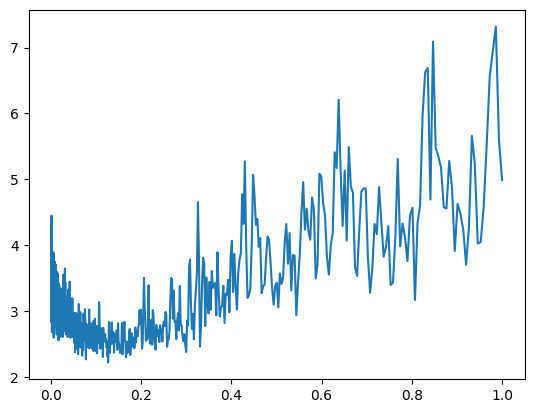

In [185]:
plt.plot(lri,lossi)  # discuss......

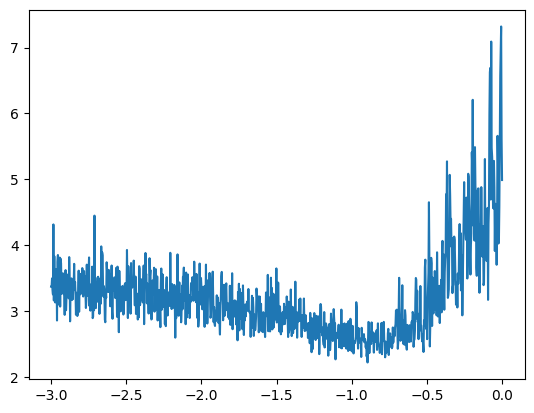

In [186]:
plt.plot(lriex,lossi)  # discuss......

In [187]:
# we can do already much better than bigram....almost...remember overfitting.... 

emb=C[X] # torch.Size([41, 3, 2])
h=torch.tanh(emb.view(-1,6) @ W1 + b1) #(41,100)
logits= h @ W2 + b2 #(41,27)
loss=F.cross_entropy(logits,Y)
loss

tensor(5.3478, grad_fn=<NllLossBackward0>)

In [188]:
# training split, dev/validation split (for hypermarameters !!), test split
# 80%, 10%, 10%
# be careful with the test eugene.....

def build_dataset(words):
    block_size =3 #context length: how many characters do we take to predict the next one ... change it !!
    X,Y = [],[]  # input & label

   
    for w in words:
        context=[0]*block_size
        for ch in w +'.':
            ix=stoi[ch]
            X.append(context)
            Y.append(ix)
      #  print(''.join(itos[i] for i in context), '--->', itos[ix])
            context=context[1:]+[ix]  # shift: crop and append
    X=torch.tensor(X)
    Y=torch.tensor(Y)
    print(X.shape,Y.shape)
    return X,Y



    

In [189]:
import random
random.seed(42)
random.shuffle(words)
n1=int(0.8*len(words))
n2=int(0.9*len(words))

Xtr,Ytr = build_dataset(words[:n1])
Xdev,Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])



torch.Size([58867, 3]) torch.Size([58867])
torch.Size([7404, 3]) torch.Size([7404])
torch.Size([7372, 3]) torch.Size([7372])


In [190]:
# and we do it again with the new datasets.......
print(Xtr.shape, Ytr.shape)

# exactly as before....
g=torch.Generator().manual_seed(123456780)# for reproducibility
C=torch.randn((28,2), generator=g)
W1=torch.randn((6,100), generator=g)
b1=torch.randn(100, generator=g)
W2=torch.randn((100,28), generator=g)
b2=torch.randn(28, generator=g)
parameters=[C,W1,b1,W2,b2]

torch.Size([58867, 3]) torch.Size([58867])


In [191]:
for p in parameters:
    p.requires_grad = True
    
    
lre=torch.linspace(-3,0,1000)
lrs= 10**lre


In [192]:
# now we train only on Xtr

lri=[]
lriex=[]
lossi=[]
    

for i in range(10000):
    
    # mini batch construct
    ix=torch.randint(0,Xtr.shape[0],(40,))
    # now we learn...forward bass -- = 73643
    emb=C[Xtr[ix]] # torch.Size([--, 3, 2])
    h=torch.tanh(emb.view(-1,6) @ W1 + b1) #(--,100)
    logits= h @ W2 + b2 #(--,27)
    loss=F.cross_entropy(logits,Ytr[ix])
   # print(i,loss.item())
    # backward pass 
    for p in parameters:
        p.grad=None
    loss.backward()
    #update
    #lr=lrs[i]
    lr= .1
    for p in parameters:
        p.data += -lr*p.grad
print(loss.item())

#track stats
#    lri.append(lr)
#    lriex.append(lre[i])
#    lossi.append(loss.item())

1.973708152770996


In [194]:
# now we evaluate on Xdev
emb=C[Xdev]
h=torch.tanh(emb.view(-1,6) @ W1 + b1) #(--,100)
logits= h @ W2 + b2 #(--,27)
loss=F.cross_entropy(logits,Ydev)
print(loss)

tensor(2.2224, grad_fn=<NllLossBackward0>)


In [195]:
# now we evaluate on Xtr..... we are NOT overfitting
emb=C[Xtr]
h=torch.tanh(emb.view(-1,6) @ W1 + b1) #(--,100)
logits= h @ W2 + b2 #(--,27)
loss=F.cross_entropy(logits,Ytr)
print(loss)

tensor(2.2002, grad_fn=<NllLossBackward0>)


In [196]:
# now we cahnge the hyper parameters....
# before....
#g=torch.Generator().manual_seed(123456780)# for reproducibility
#C=torch.randn((28,2), generator=g)
#W1=torch.randn((6,100), generator=g)
#b1=torch.randn(100, generator=g)
#W2=torch.randn((100,28), generator=g)
#b2=torch.randn(28, generator=g)
#parameters=[C,W1,b1,W2,b2]

g=torch.Generator().manual_seed(123456780)# for reproducibility
C=torch.randn((28,2), generator=g)
W1=torch.randn((6,300), generator=g)
b1=torch.randn(300, generator=g)
W2=torch.randn((300,28), generator=g)
b2=torch.randn(28, generator=g)
parameters=[C,W1,b1,W2,b2]

In [197]:
print(sum(p.nelement() for p in parameters)) # number of parameter in total... before 3584

10584


In [198]:
lri=[]
lriex=[]
lossi=[]
stepi=[]
for p in parameters:
    p.requires_grad = True

for i in range(10000):
    
    # mini batch construct
    ix=torch.randint(0,Xtr.shape[0],(40,))
    # now we learn...forward bass -- = 73643
    emb=C[Xtr[ix]] # torch.Size([--, 3, 2])
    h=torch.tanh(emb.view(-1,6) @ W1 + b1) #(--,100)
    logits= h @ W2 + b2 #(--,27)
    loss=F.cross_entropy(logits,Ytr[ix])
   # print(i,loss.item())
    # backward pass 
    for p in parameters:
        p.grad=None
    loss.backward()
    #update
    #lr=lrs[i]
    lr= .1
    for p in parameters:
        p.data += -lr*p.grad
    stepi.append(i)
    lossi.append(loss.item())

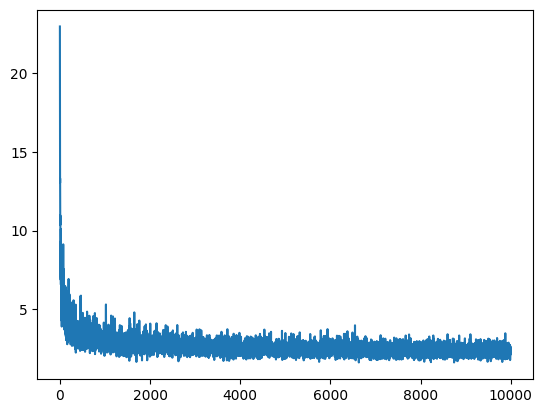

In [199]:
plt.plot(stepi,lossi)

In [ ]:
# Exercise with different hypermarameters and learning rate.....describe and discuss results....

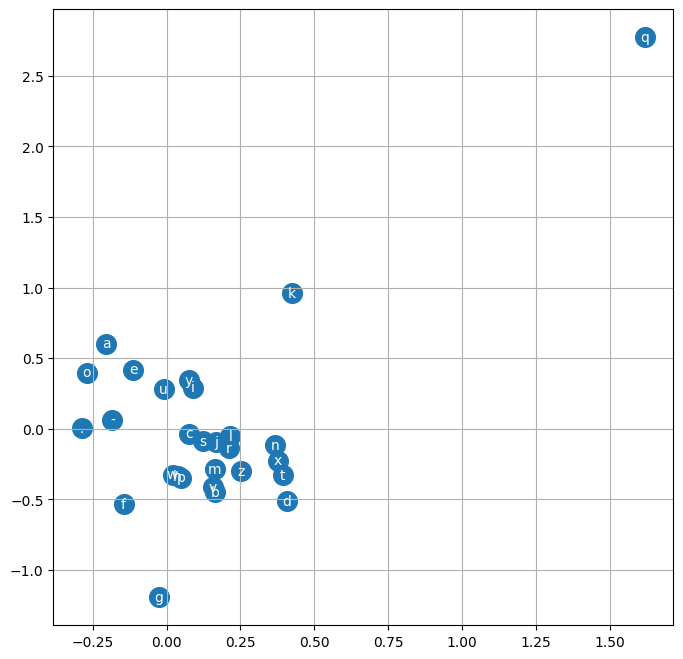

In [200]:
#visualizing the embedding.....

plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(),itos[i], ha="center",va="center", color="white")
    plt.grid('minor')

In [201]:
# we scale up the embedding dimension and see what happen


g=torch.Generator().manual_seed(123456780)# for reproducibility
C=torch.randn((28,10), generator=g)
W1=torch.randn((30,200), generator=g)
b1=torch.randn(200, generator=g)
W2=torch.randn((200,28), generator=g)
b2=torch.randn(28, generator=g)
parameters=[C,W1,b1,W2,b2]

In [202]:
print(sum(p.nelement() for p in parameters)) # number of parameter in total

12108


In [203]:
lri=[]
lriex=[]
lossi=[]
stepi=[]

for p in parameters:
    p.requires_grad = True

In [204]:
# do lr =0.1 and then 0.01 and look at the performance....


for i in range(200000):
    
    # mini batch construct
    ix=torch.randint(0,Xtr.shape[0],(40,))
    # now we learn...forward bass -- = 73643
    emb=C[Xtr[ix]] # torch.Size([--, 3, 2])
    h=torch.tanh(emb.view(-1,30) @ W1 + b1) #(--,100)
    logits= h @ W2 + b2 #(--,27)
    loss=F.cross_entropy(logits,Ytr[ix])
   # print(i,loss.item())
    # backward pass 
    for p in parameters:
        p.grad=None
    loss.backward()
    #update
    #lr=lrs[i]
    lr= .1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr*p.grad
    stepi.append(i)
    lossi.append(loss.log10().item()) # note the log10 !!

KeyboardInterrupt: 

In [ ]:
plt.plot(stepi,lossi)

In [ ]:
emb=C[Xtr]
h=torch.tanh(emb.view(-1,30) @ W1 + b1) #(--,100)   30 not 6 !
logits= h @ W2 + b2 #(--,27)
loss=F.cross_entropy(logits,Ytr)
loss

In [ ]:
emb=C[Xdev]
h=torch.tanh(emb.view(-1,30) @ W1 + b1) #(--,100)
logits= h @ W2 + b2 #(--,27)
loss=F.cross_entropy(logits,Ydev)
loss

In [ ]:
# several (hyper)parameters to paly with: number of layer, numbers of neurons fro layers, embedding dimensions..dimension of the batches, learning rate....
# now you can read the cited paper on language models......


In [ ]:
# sampling from the model.....

g=torch.Generator().manual_seed(12345678+10)

for _ in range(30):
    out=[]
    context=[0]*block_size
    while True:
        emb=C[torch.tensor([context])]
        h=torch.tanh(emb.view(1,-1) @ W1 + b1) 
        logits= h @ W2 + b2
        probs=F.softmax(logits,dim=1)
        ix=torch.multinomial(probs,num_samples=1,generator=g).item()
        context=context[1:]+[ix]
        out.append(ix)
        if ix==0:
            break
        
    print(''.join(itos[i] for i in out))
        